<a href="https://colab.research.google.com/github/jcast043/AI-Tests/blob/main/Yet_another_copy_of_MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import **Pytorch** libraries and APIs.


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import math

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')

    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')

    plt.show(block=True)


In [5]:
# Hyperparameters and Data loaders
num_epochs = 25
num_classes = 10
batch_size = 64
learning_rate = 0.002


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 348kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.6MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# neural network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),

            nn.Linear(128, 64),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        out = self.classifier(x)

        return out


model=ConvNet()
model.cuda()
model.train()

ConvNet(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [8]:
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.3),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.3),

            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        out = self.features(x)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = F.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out) #logits for crossentropy loss


      # out = self.fc1(out)
       # out = self.fc2(out)
       # out = self.fc3(out)

        return out


model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) #weight decay = L2 regularization

steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1e4
)

In [9]:
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Epoch [1/25], Step [0/938], Loss: 2.2884, Accuracy: 14.06%
Epoch [1/25], Step [150/938], Loss: 1.2193, Accuracy: 65.62%
Epoch [1/25], Step [300/938], Loss: 0.5252, Accuracy: 87.50%
Epoch [1/25], Step [450/938], Loss: 0.6162, Accuracy: 81.25%
Epoch [1/25], Step [600/938], Loss: 0.3223, Accuracy: 89.06%
Epoch [1/25], Step [750/938], Loss: 0.3072, Accuracy: 85.94%
Epoch [1/25], Step [900/938], Loss: 0.3494, Accuracy: 89.06%
Epoch [2/25], Step [0/938], Loss: 0.3014, Accuracy: 89.06%
Epoch [2/25], Step [150/938], Loss: 0.1956, Accuracy: 93.75%
Epoch [2/25], Step [300/938], Loss: 0.2090, Accuracy: 95.31%
Epoch [2/25], Step [450/938], Loss: 0.2517, Accuracy: 93.75%
Epoch [2/25], Step [600/938], Loss: 0.1989, Accuracy: 95.31%
Epoch [2/25], Step [750/938], Loss: 0.3615, Accuracy: 87.50%
Epoch [2/25], Step [900/938], Loss: 0.0871, Accuracy: 98.44%
Epoch [3/25], Step [0/938], Loss: 0.1310, Accuracy: 96.88%
Epoch [3/25], Step [150/938], Loss: 0.0879, Accuracy: 98.44%
Epoch [3/25], Step [300/938], 

Device: cuda
Accuracy of the model on the 10000 test images (FGSM step_size=0.5): 11.29 %
Original images (first 10 from last batch):


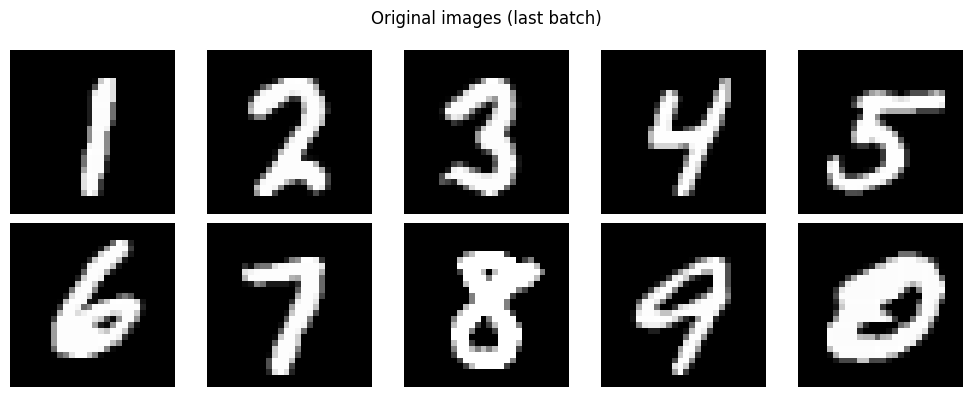

Adversarial images (first 10) with T / P / conf:


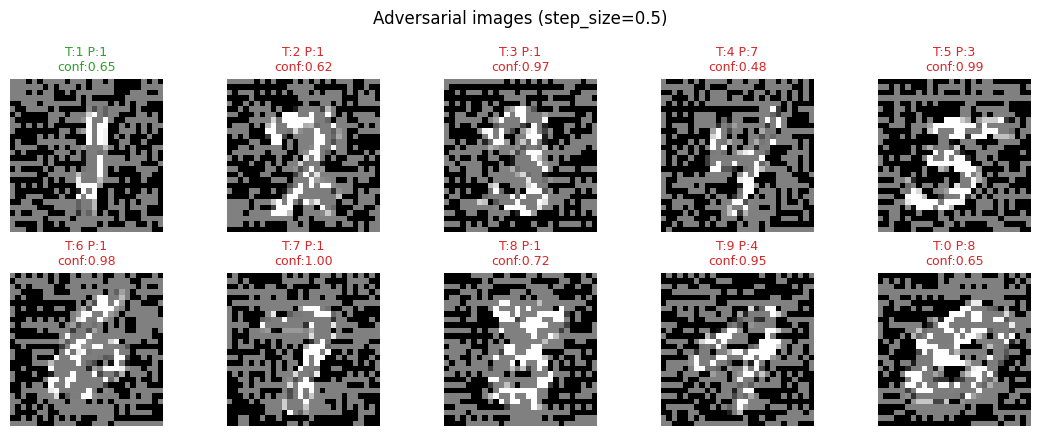

In [57]:

# -----------------------
# FGSM Model
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

try:
    model
except NameError:
    raise RuntimeError("No `model` variable found. Train or load your model first (name it `model`).")

model = model.to(device)
model.eval()

try:
    criterion
except NameError:
    criterion = torch.nn.CrossEntropyLoss()

try:
    test_loader
except NameError:
    print("No test_loader found — building default MNIST test_loader (batch_size=256).")
    transform = transforms.Compose([transforms.ToTensor()])  # match how you trained
    test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

def show_images(images, ncols=5, title=None):
    """
    images: tensor [N,1,28,28] or [N,28,28] in [0,1]
    """
    imgs = images.detach().cpu()
    n = imgs.shape[0]
    cols = ncols
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols*2, rows*2))
    if title:
        plt.suptitle(title)
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        img = imgs[i]
        if img.ndim == 3 and img.shape[0] == 1:
            img = img.squeeze(0)
        ax.imshow(img, cmap='gray', interpolation='nearest')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_images_withPred(images, labels, preds, conf, max_images=10, suptitle=None):
    """
    images: tensor [N,1,28,28] or [N,28,28]
    labels, preds: iterable of ints
    conf: tensor/list of floats in [0,1]
    """
    imgs = images.detach().cpu()
    labels = torch.as_tensor(labels).cpu()
    preds  = torch.as_tensor(preds).cpu()
    conf   = torch.as_tensor(conf).cpu()

    n = min(len(imgs), max_images)
    cols = min(5, n)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols*2.2, rows*2.2))
    if suptitle:
        plt.suptitle(suptitle)
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        img = imgs[i]
        if img.ndim == 3 and img.shape[0] == 1:
            img = img.squeeze(0)
        ax.imshow(img, cmap='gray', interpolation='nearest')
        t = int(labels[i].item())
        p = int(preds[i].item())
        c = float(conf[i].item())
        color = 'tab:green' if p == t else 'tab:red'
        ax.set_title(f"T:{t} P:{p}\nconf:{c:.2f}", color=color, fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# -----------------------
# FGSM function
# -----------------------
def fgsm(model, criterion, images, labels, step_size):
    # images is expected on the device and requires_grad True for FGSM
    images = images.clone().detach().to(device)
    images.requires_grad = True

    outputs = model(images)            # forward pass
    model.zero_grad()
    loss = criterion(outputs, labels.to(device))
    loss.backward()

    ae_images = images + step_size * images.grad.sign()
    ae_images = torch.clamp(ae_images, 0.0, 1.0)
    return ae_images

# -----------------------
# Main FGSM loop
# -----------------------
step_size = 0.5
model.eval()

correct = 0
total = 0
last_images = None
last_labels = None
last_ae_images = None
last_outputs = None

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    ae_images = fgsm(model, criterion, images, labels, step_size=step_size)

    outputs = model(ae_images)                  # logits on adversarial images
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    last_images = images.detach().cpu()
    last_labels = labels.detach().cpu()
    last_ae_images = ae_images.detach().cpu()
    last_outputs = outputs.detach().cpu()

acc = (correct / total) * 100.0
print(f"Accuracy of the model on the {total} test images (FGSM step_size={step_size}): {acc:.2f} %")


# Display original
print("Original images (first 10 from last batch):")
show_images(last_images[:10], title="Original images (last batch)")

# Display adversarial examples (first 10) and predictions/confidence
# Compute predictions and confidences from outputs on adversarial examples
probs = F.softmax(last_outputs, dim=1)
confidences, preds = probs.max(dim=1)

print("Adversarial images (first 10) with T / P / conf:")
show_images_withPred(last_ae_images[:10], last_labels[:10], preds[:10].cpu(), confidences[:10].cpu(),
                     max_images=10, suptitle=f"Adversarial images (step_size={step_size})")

Accuracy of the model on the 10000 test images: 0.0 %


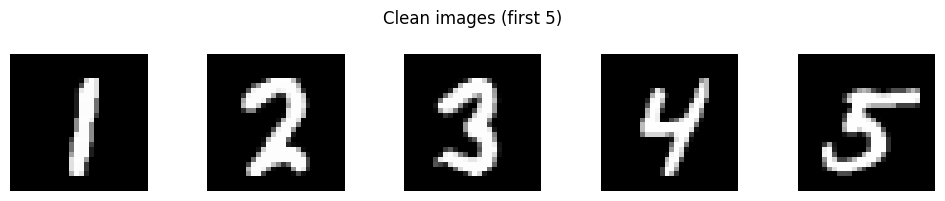

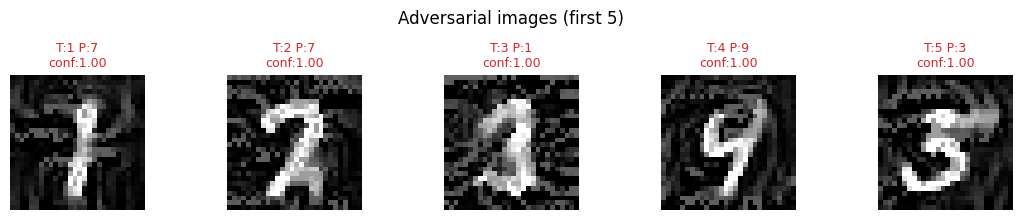

In [56]:

def pgd_attack(model, images, criterion, labels, eps=0.5, step_size=0.0125, iters=30) :
    # Move images and labels to the GPU for faster computation.
    images = images.cuda()
    labels = labels.cuda()

    # Store the original images to ensure the final adversarial image is within a certain distance from the original.
    ori_images = images.data

    # Start the iterative process for PGD.
    for i in range(iters) :

        images.requires_grad = True

        outputs = model(images)

        cost = criterion(outputs, labels)
        model.zero_grad()


        cost.backward()


        adv_images = images + step_size*images.grad.sign()

        eta = adv_images - ori_images

        eta = torch.clamp(eta, min=-eps, max=eps)

        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    # Return the final adversarial images after all iterations.
    return images


# Set the model to evaluation mode.
model.eval()

# Initialize counters for tracking correct predictions on adversarial examples generated by PGD.
correct = 0
total = 0
# Iterate through each batch of images and labels in the test data loader.
for images, labels in test_loader:
    # Move the images and labels to the GPU.
    images = images.cuda()
    labels = labels.cuda()

    ae_images = pgd_attack(model, images, criterion,labels)


    outputs = model(ae_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)

    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

probs = F.softmax(outputs, dim=1)
preds = probs.argmax(dim=1)
confidences = probs.max(dim=1).values
# ----------------------

show_images(images[:5].detach(), title="Clean images (first 5)")
show_images_withPred(
    ae_images[:5].detach(),
    labels[:5],
    preds[:5],
    confidences[:5],
    max_images=5,
    suptitle="Adversarial images (first 5)"
)